In [1]:
import json, re
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\migue\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Inicio

La primera acción será leer el dataset con el que vamos a entrenar el algoritmo (training_data) y el dataset al que le vamos a aplicar nuestro modelo entrenado (steam_reviews)

Luego procedemos a eliminar columnas superfluas

In [2]:
training_data = pd.read_csv("./data/HateTweets.csv")
steam_reviews = pd.read_csv("./data/dataset.csv")


steam_reviews.drop(columns=['app_id'], axis=1, inplace=True)
steam_reviews.drop(columns=['app_name'], axis=1, inplace=True)
steam_reviews.drop(columns=['review_score'], axis=1, inplace=True)
steam_reviews.drop(columns=['review_votes'], axis=1, inplace=True)

training_data.head()

id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation

## Trabajo con el dataset "training_data"

Procesamos los tweets de entrenamiento para eliminar emoticonos, enlaces, saltos de línea y demás elementos que no nos interesan
además del stop words (en inglés porque el dataset es enteramente en ese idioma)

Para ello creamos una función que aplicará todas estas reglas a los tweets del dataset

In [3]:
stop_words = set(stopwords.words('english'))
def limpiado_tweets (tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags = re.MULTILINE)
    tweet = re.sub(r'\@w+|\#','', tweet)
    tweet = re.sub(r'[^\w\s]','',tweet)
    review = re.sub(r'ð','',tweet)
    tweet = re.sub(r'____________________________________','',tweet)
    tweet = re.sub(r'user','', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_tweets = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_tweets)

training_data.tweet = training_data['tweet'].apply(limpiado_tweets)
training_data = training_data.drop_duplicates('tweet')

training_data.head()

id  label                                              tweet
0   1      0  father dysfunctional selfish drags kids dysfun...
1   2      0  thanks lyft credit cant use cause dont offer w...
2   3      0                                     bihday majesty
3   4      0              model love u take u time urð ðððð ððð
4   5      0                      factsguide society motivation

## Problemas de balanceo...

En este gráfico se muestra la proporción de tweets con hate-seech (1) con respecto a los que no lo tienen (0). Como se puede ver está totalmente desbalanceado por ello, si no queremos que nuestro algoritmo falle en favor del mayoritario, necesitamos usar opciones de balanceo 

<Axes: xlabel='label', ylabel='count'>

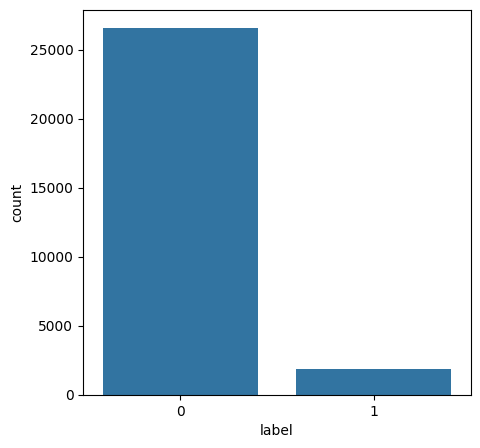

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(5,5))
sns.countplot(x='label', data = training_data)

Dividimos el dataset entre los tweets con y sin hate-speech

In [5]:
non_hate_tweets = training_data[training_data.label == 0]
neg_tweets = training_data[training_data.label == 1]

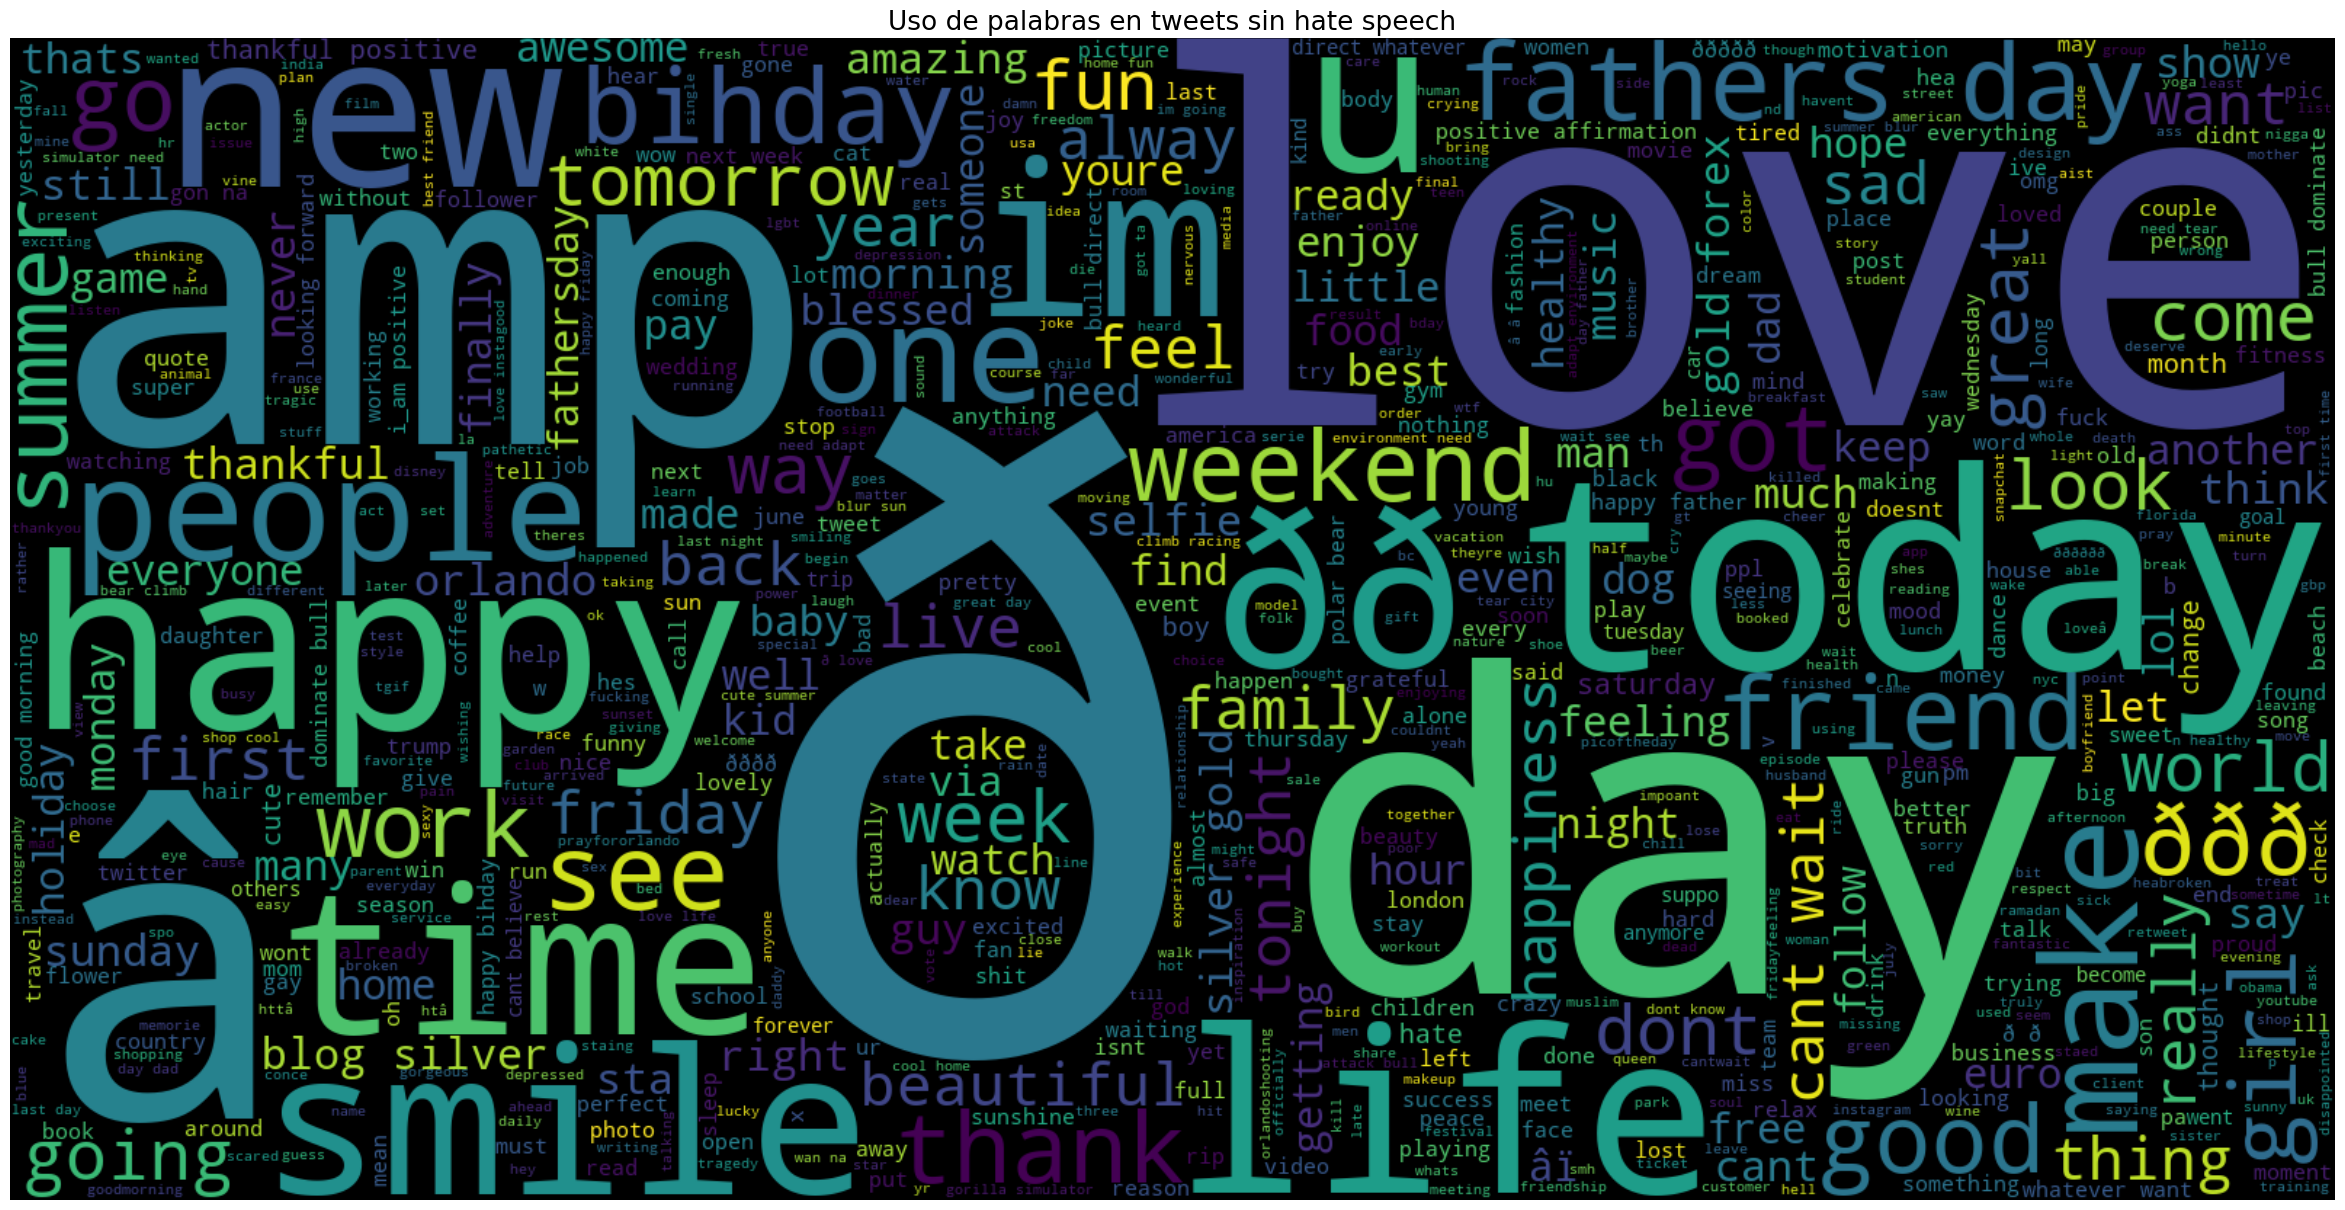

In [6]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

text = ' '.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize=(30,20), facecolor='white')
wordcloud = WordCloud(max_words=700, width=1600, height=800).generate(text)
plt.title('Uso de palabras en tweets sin hate speech', fontsize = 19)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

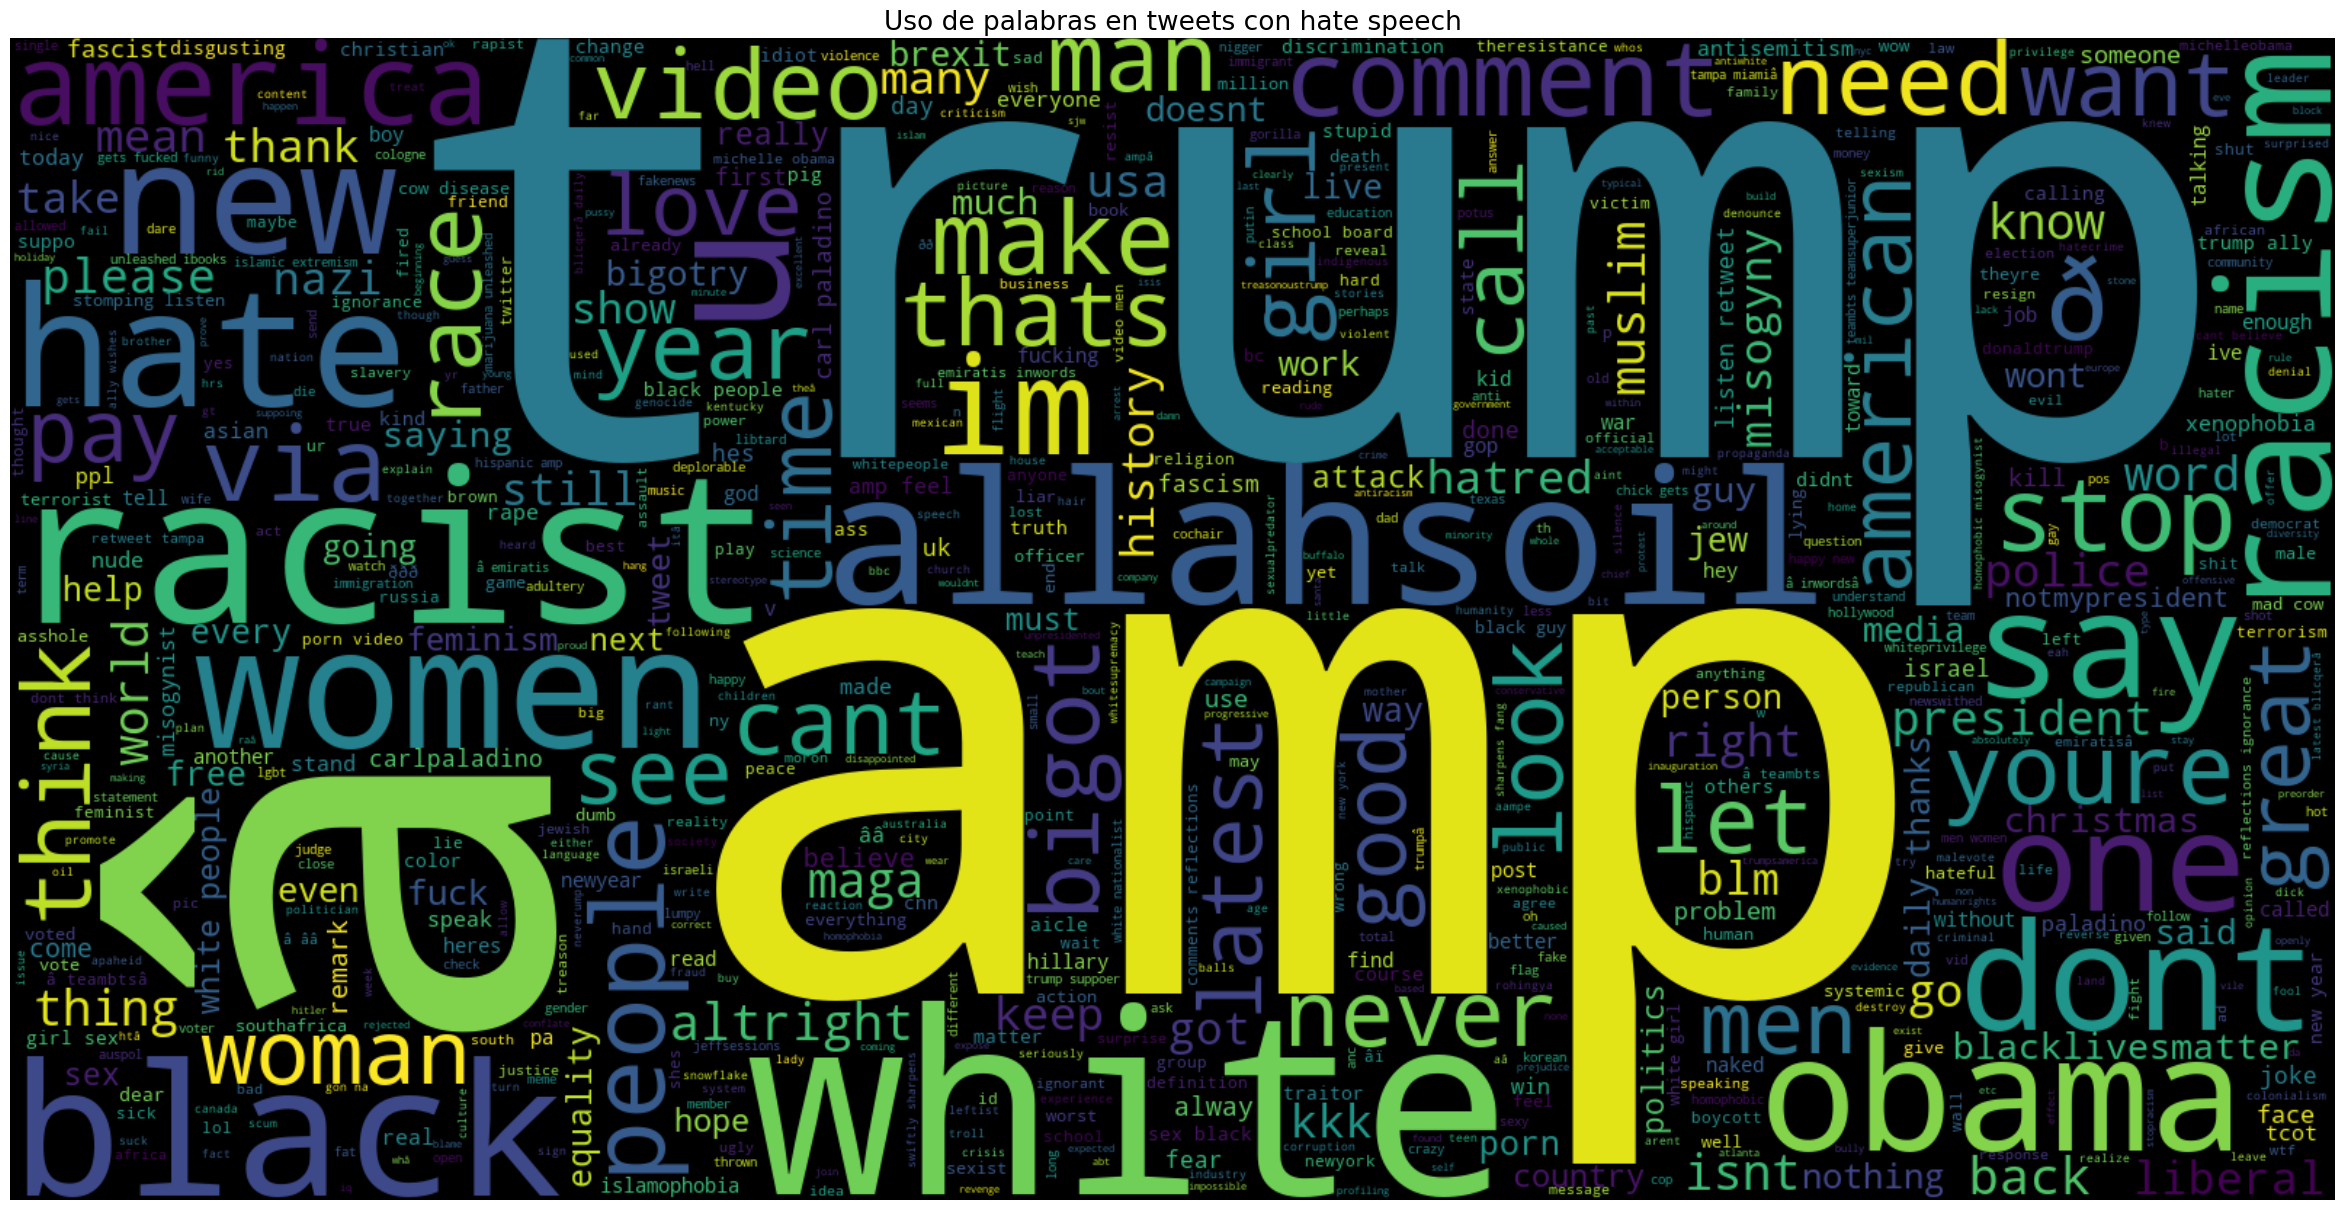

In [9]:
text = ' '.join([word for word in neg_tweets['tweet']])
plt.figure(figsize=(30,20), facecolor='None')
wordcloud = WordCloud(max_words=700, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Uso de palabras en tweets con hate speech', fontsize = 19)
plt.show()

##  Solución, SMOTE:

Como hemos visto, el dataset está desbalanceado, ya que hay muchos más tweets sin hate speech que con él.
Para solucionarlo utilizamos el algoritmo SMOTE.

Para ello lo primero es "transformar" letras en números y así poder tratarlos con SMOTE

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler 


y = training_data['label'] 
X = training_data.drop('label', axis=1) 

Label_y=LabelEncoder()
X = X.apply(LabelEncoder().fit_transform)
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)

In [8]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sampling = SMOTE(random_state=42)
X, y = sampling.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y))

Resampled dataset shape Counter({0: 26557, 1: 26557})


In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.30, stratify=y, random_state=1)

In [10]:
print(x_train.head())

             id     tweet
19960  0.701782  1.562138
49249 -0.188021  0.533268
27826  1.660903 -0.147599
38380 -0.633565 -1.690379
40536  0.579355  1.292731


In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans()

param_grid = {
    'n_neighbors':np.arange(1, 50),
    'weights':['uniform', 'distance'],
    'algorithm':['lloyd', 'elkan', 'auto', 'full']}

# Algoritmos clasificación

# KNeighborsClassifier

Ahora vamos a crear varios modelos, intentando buscar los parametros óptimos.

Para empezar, vamos con KNeighborsClassifier. La dinamica es la misma para todos ellos, creamos un param_grid que nos permite probar varias variables dentro de un rango y con GridSearchCV hacemos las sucesivas pruebas. Este nos dirá cual es la opción más optima

Fitting 5 folds for each of 392 candidates, totalling 1960 fits
{'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'distance'}
0.7986593347183382


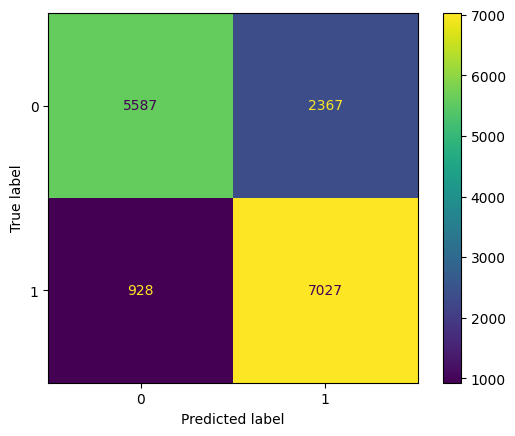

              precision    recall  f1-score   support

           0       0.86      0.70      0.77      7954
           1       0.75      0.88      0.81      7955

    accuracy                           0.79     15909
   macro avg       0.80      0.79      0.79     15909
weighted avg       0.80      0.79      0.79     15909



In [10]:
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
 
param_grid = {
    'n_neighbors':np.arange(1, 50),
    'weights':['uniform', 'distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}#nombre de la variable en la documentacion 
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,scoring='f1', return_train_score=False,verbose=1)#4 para entrenar 1 para test, una f1
grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

Kne_score = grid.best_score_
Kne_params = grid.best_params_

grid_predictions = grid.predict(x_test) 

cm = confusion_matrix(y_test, grid_predictions, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid.classes_)
disp.plot()
plt.show()
 
# print classification report 
print(classification_report(y_test, grid_predictions)) 

## ¿Qué estamos viendo?

Con este módelo lo que podemos comprobar es que la cantidad de casos en la que dice acertadamente que un tweet tiene hate speech es mucho mayor (en torno a 7000) a los falsos negativos (en torno a 900). Es decir, aunque sí que hay falsos negativos, es un número bastante marginal comparado con los verdaderos.

Por otro lado, en los casos en los que el modelo predice hate-speech, pero no lo hay (falsos positivos) es algo mayor. Nuestro objetivo es tener redes sociales sanas y limpias, por lo tanto, el que haya más posibilidades de que un mensaje sea marcado como falso positivo que como falso negativo es asimible y preferible

# LogisticRegression

El segundo modelo que vamos a construir es uno basado en el algoritmo "logisticregression", con la misma forma de proceder que el anterior

Fitting 5 folds for each of 756 candidates, totalling 3780 fits
{'C': 0.1, 'class_weight': 'balanced', 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'liblinear'}
0.5105742887029592


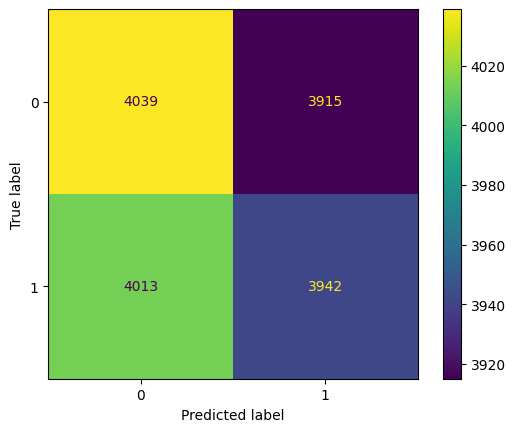

              precision    recall  f1-score   support

           0       0.50      0.51      0.50      7954
           1       0.50      0.50      0.50      7955

    accuracy                           0.50     15909
   macro avg       0.50      0.50      0.50     15909
weighted avg       0.50      0.50      0.50     15909



In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")   

# Perform grid search with cross-validation
ss = StratifiedKFold(n_splits=5, shuffle=True,  random_state=1)
param_grid = {'penalty': ['l2','l1','elasticnet'],
             'solver':['sag','lbfgs','newton_cg'],
              'class_weight':['dict','balanced'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'multi_class':['auto', 'ovr', 'multinomial']
             }
grid = GridSearchCV(LogisticRegression(random_state=0), param_grid, cv=ss,scoring='f1', return_train_score=False,verbose=1)
grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

logReg_score = grid.best_score_
logReg_params = grid.best_params_

grid_predictions = grid.predict(x_test) 

cm = confusion_matrix(y_test, grid_predictions, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid.classes_)
disp.plot()
plt.show()
 
# print classification report 
print(classification_report(y_test, grid_predictions)) 

## ¿Que estamos viendo?

Evidentemente, este modelo no es para nosotros. Principalmente, porque no podemos permitirnos que un modelo que tiene que mantener una red social sana tenga un número tan elevado de falsos negativos, ya que se nos está colando hate-speech por todos lados.

## Stochastic Gradient Descent (SGD)

Fitting 5 folds for each of 945 candidates, totalling 4725 fits
{'alpha': 0.1, 'epsilon': 0.1, 'l1_ratio': 0.9, 'penalty': 'elasticnet'}
0.6666546913358481


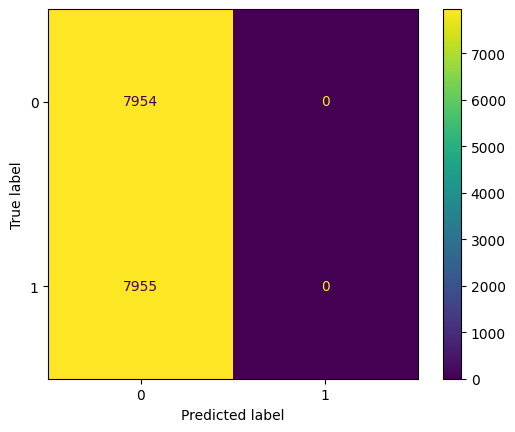

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      7954
           1       0.00      0.00      0.00      7955

    accuracy                           0.50     15909
   macro avg       0.25      0.50      0.33     15909
weighted avg       0.25      0.50      0.33     15909



In [16]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier


param_grid = {'penalty': ['l2','l1','elasticnet'],
              'l1_ratio': [0, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 1],
              'epsilon': [0.1,0.2,0.3,0.4,0.15],
              'alpha': [10 ** x for x in range(-6, 1)]
             }

grid = GridSearchCV(SGDClassifier(random_state=41, max_iter=1000, tol=1e-3), param_grid, cv=5,scoring='f1', return_train_score=False,verbose=1)

grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

sgd_score = grid.best_score_
sgd_params = grid.best_params_

grid_predictions = grid.predict(x_test) 

cm = confusion_matrix(y_test, grid_predictions, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, grid_predictions)) 

## Support Vector Machines

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.511 total time=  12.6s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.501 total time=  12.7s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.516 total time=  12.8s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.517 total time=  12.5s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.513 total time=  12.7s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.525 total time=  14.4s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.513 total time=  14.2s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.529 total time=  14.8s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.531 total time=  14.6s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.520 total time=  14.5s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.556 total time=  30.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rb

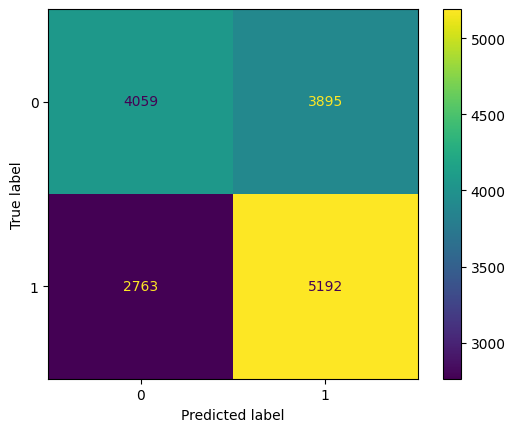

              precision    recall  f1-score   support

           0       0.59      0.51      0.55      7954
           1       0.57      0.65      0.61      7955

    accuracy                           0.58     15909
   macro avg       0.58      0.58      0.58     15909
weighted avg       0.58      0.58      0.58     15909



In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100, 1000],
			'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
			'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, cv=5)

grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

svc_score = grid.best_score_
svc_params = grid.best_params_

grid_predictions = grid.predict(x_test) 

cm = confusion_matrix(y_test, grid_predictions, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, grid_predictions)) 

## Random Forest

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=0.793 total time=  14.6s
[CV 2/5] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=0.779 total time=  14.6s
[CV 3/5] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=0.783 total time=  14.5s
[CV 4/5] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=0.777 total time=  14.6s
[CV 5/5] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=0.780 total time=  14.5s
[CV 1/5] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200;, score=0.791 total time=  29.3s
[CV 2/5] END bootstrap=True, max_dept

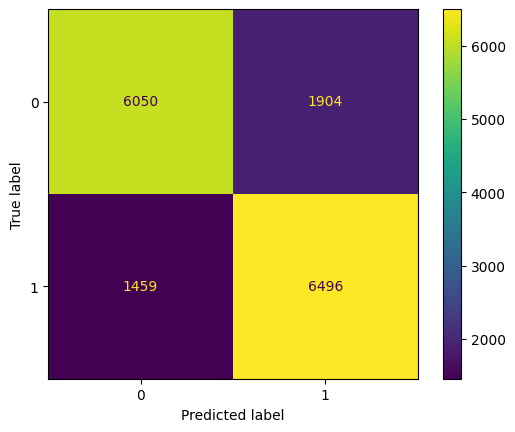

              precision    recall  f1-score   support

           0       0.81      0.76      0.78      7954
           1       0.77      0.82      0.79      7955

    accuracy                           0.79     15909
   macro avg       0.79      0.79      0.79     15909
weighted avg       0.79      0.79      0.79     15909



In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5,scoring='f1', return_train_score=False,verbose=3)

grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

randomForest_score = grid.best_score_
randomForest_params = grid.best_params_

grid_predictions = grid.predict(x_test) 

cm = confusion_matrix(y_test, grid_predictions, labels=grid.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=grid.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, grid_predictions)) 

## Bagged Decision Trees

Aquí utilizamos una técnica que consiste en escoger un algoritmo (en este caso DecisionTreeClassifier) y definir un número de estimadores (instancias de este) que trabajarán para obtener la predicción.

In [13]:
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print("TRAINIG RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    #print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print(f"F1-SCORE:\n{f1_score(y_train, y_train_pred, average='weighted'):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

    print("\nTESTING RESULTS: \n===============================")
    clf_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"F1-SCORE:\n{f1_score(y_test, y_test_pred, average='weighted'):.4f}")
    #print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")

TRAINIG RESULTS: 
CONFUSION MATRIX:
[[18590     0]
 [    0 18589]]
F1-SCORE:
1.0000
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision      1.0      1.0       1.0        1.0           1.0
recall         1.0      1.0       1.0        1.0           1.0
f1-score       1.0      1.0       1.0        1.0           1.0
support    18590.0  18589.0       1.0    37179.0       37179.0

TESTING RESULTS: 
CONFUSION MATRIX:
[[6033 1934]
 [1446 6522]]
F1-SCORE:
0.7877
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.806659     0.771287  0.787888      0.788973      0.788972
recall        0.757249     0.818524  0.787888      0.787886      0.787888
f1-score      0.781173     0.794204  0.787888      0.787688      0.787689
support    7967.000000  7968.000000  0.787888  15935.000000  15935.000000


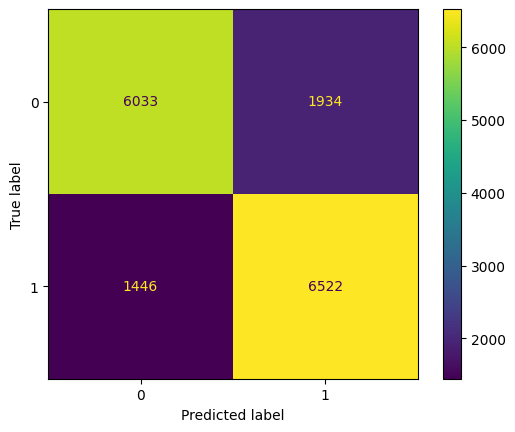

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=1500,
                  random_state=42)


In [14]:
parameters = {
    'n_estimators':[1500,400,500],
    'random_state':[42,52],
    'max_samples' :[1.0,1.5,2.0]
}

tree = DecisionTreeClassifier()

gridsearch = GridSearchCV(BaggingClassifier(estimator=tree),
                              parameters,
                              n_jobs=-1, 
                              cv=2,  
                              return_train_score=True)

gridsearch.fit(x_train, y_train)
best_model = gridsearch.best_estimator_
# x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.30, stratify=y, random_state=1)
evaluate(gridsearch, x_train, x_test, y_train, y_test)
grid_predictions = gridsearch.predict(x_test)


bagged_score = gridsearch.best_score_
bagged_params = gridsearch.best_params_


cm = confusion_matrix(y_test, grid_predictions, labels=gridsearch.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=gridsearch.classes_)
disp.plot()
plt.show()

print("===========================================================")
print(best_model)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.869314193513101


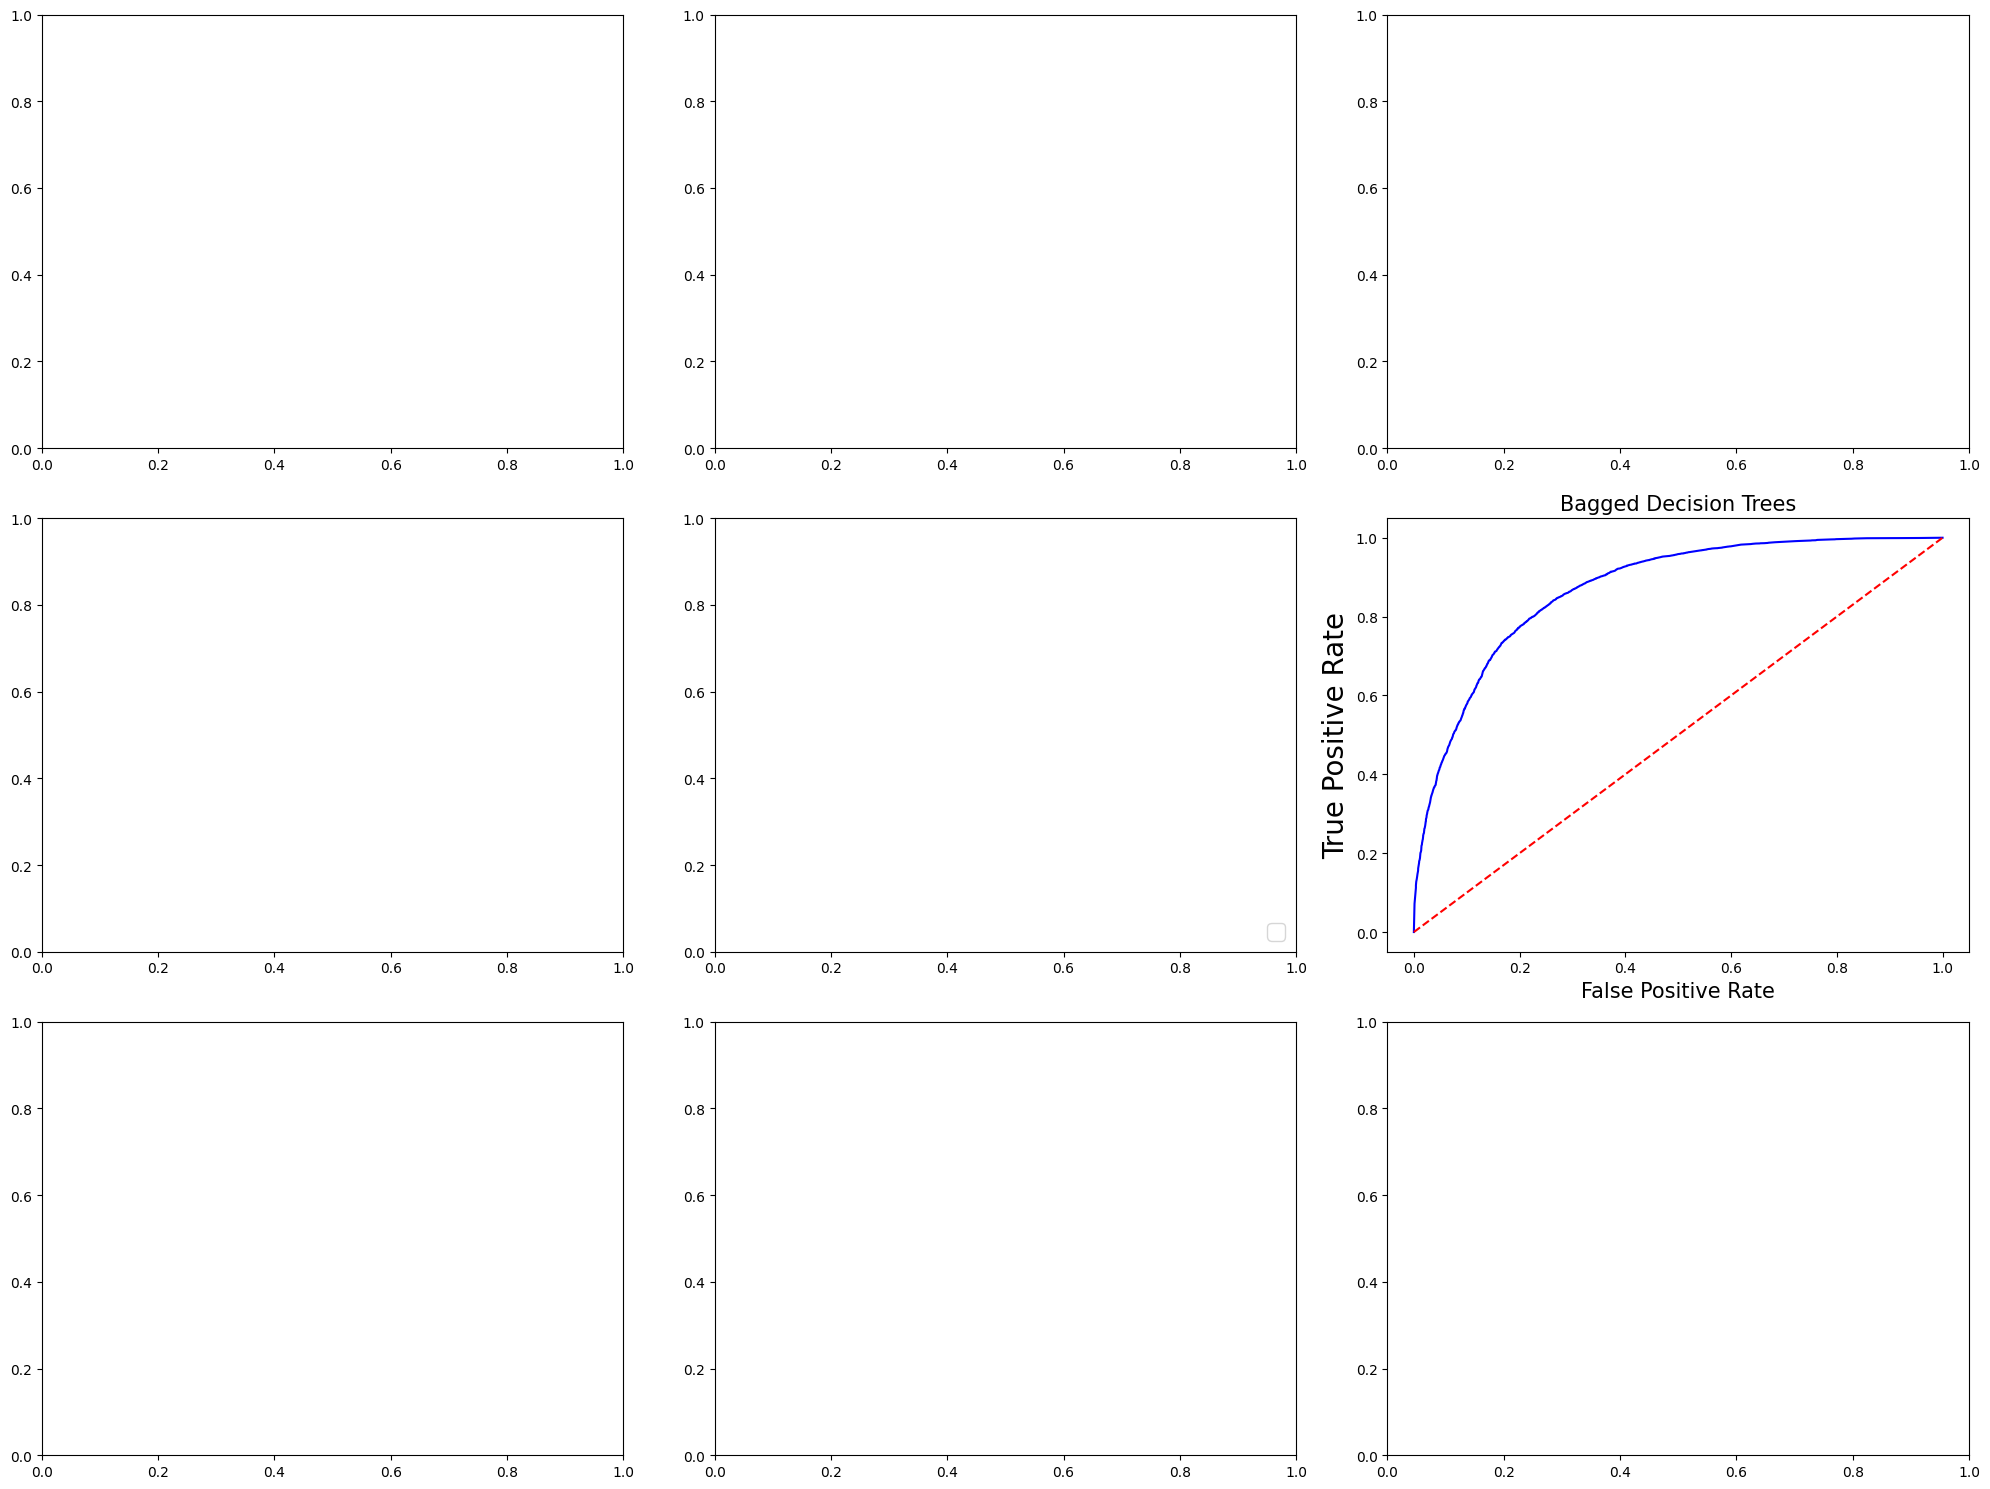

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt

fig, ax_arr = plt.subplots(nrows = 3, ncols = 3, figsize = (20,15))
#Bagged Decision Trees ----------------------------------
tree = DecisionTreeClassifier()
bagging_clf = BaggingClassifier(estimator=tree, n_estimators=1500, random_state=42)
bagging_clf.fit(x_train, y_train)
probs = bagging_clf.predict_proba(x_test)
preds = probs[:,1]
fpr_bdt, tpr_bdt, threshold_bdt = metrics.roc_curve(y_test, preds)
roc_auc_gau = metrics.auc(fpr_bdt, tpr_bdt)

print(roc_auc_gau)

ax_arr[1,2].plot(fpr_bdt, tpr_bdt, 'b', label = 'AUC = %0.2f' % roc_auc_gau)
ax_arr[1,2].plot([0, 1], [0, 1],'r--')
ax_arr[1,2].set_title('Bagged Decision Trees',fontsize=15)
ax_arr[1,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,1].legend(loc = 'lower right', prop={'size': 16})


plt.subplots_adjust(wspace=0.2)
plt.tight_layout() 

## Esquema para seleccionar el mejor modelo

In [9]:
models = pd.DataFrame({
                'Models': ['KNeighborsClassifier', 'LogisticRegression', 'Stochastic Gradient Descent (SGD)',
                           'Support Vector Machines', 'Random Forest'],
                'params' : [Kne_score, logReg_score, sgd_score , svc_score , randomForest_score, bagged_score],
                'Score':  [Kne_score, logReg_score, sgd_score, svc_score, randomForest_score, bagged_score]})

models.sort_values(by='Score', ascending=False)

NameError: name 'Kne_score' is not defined

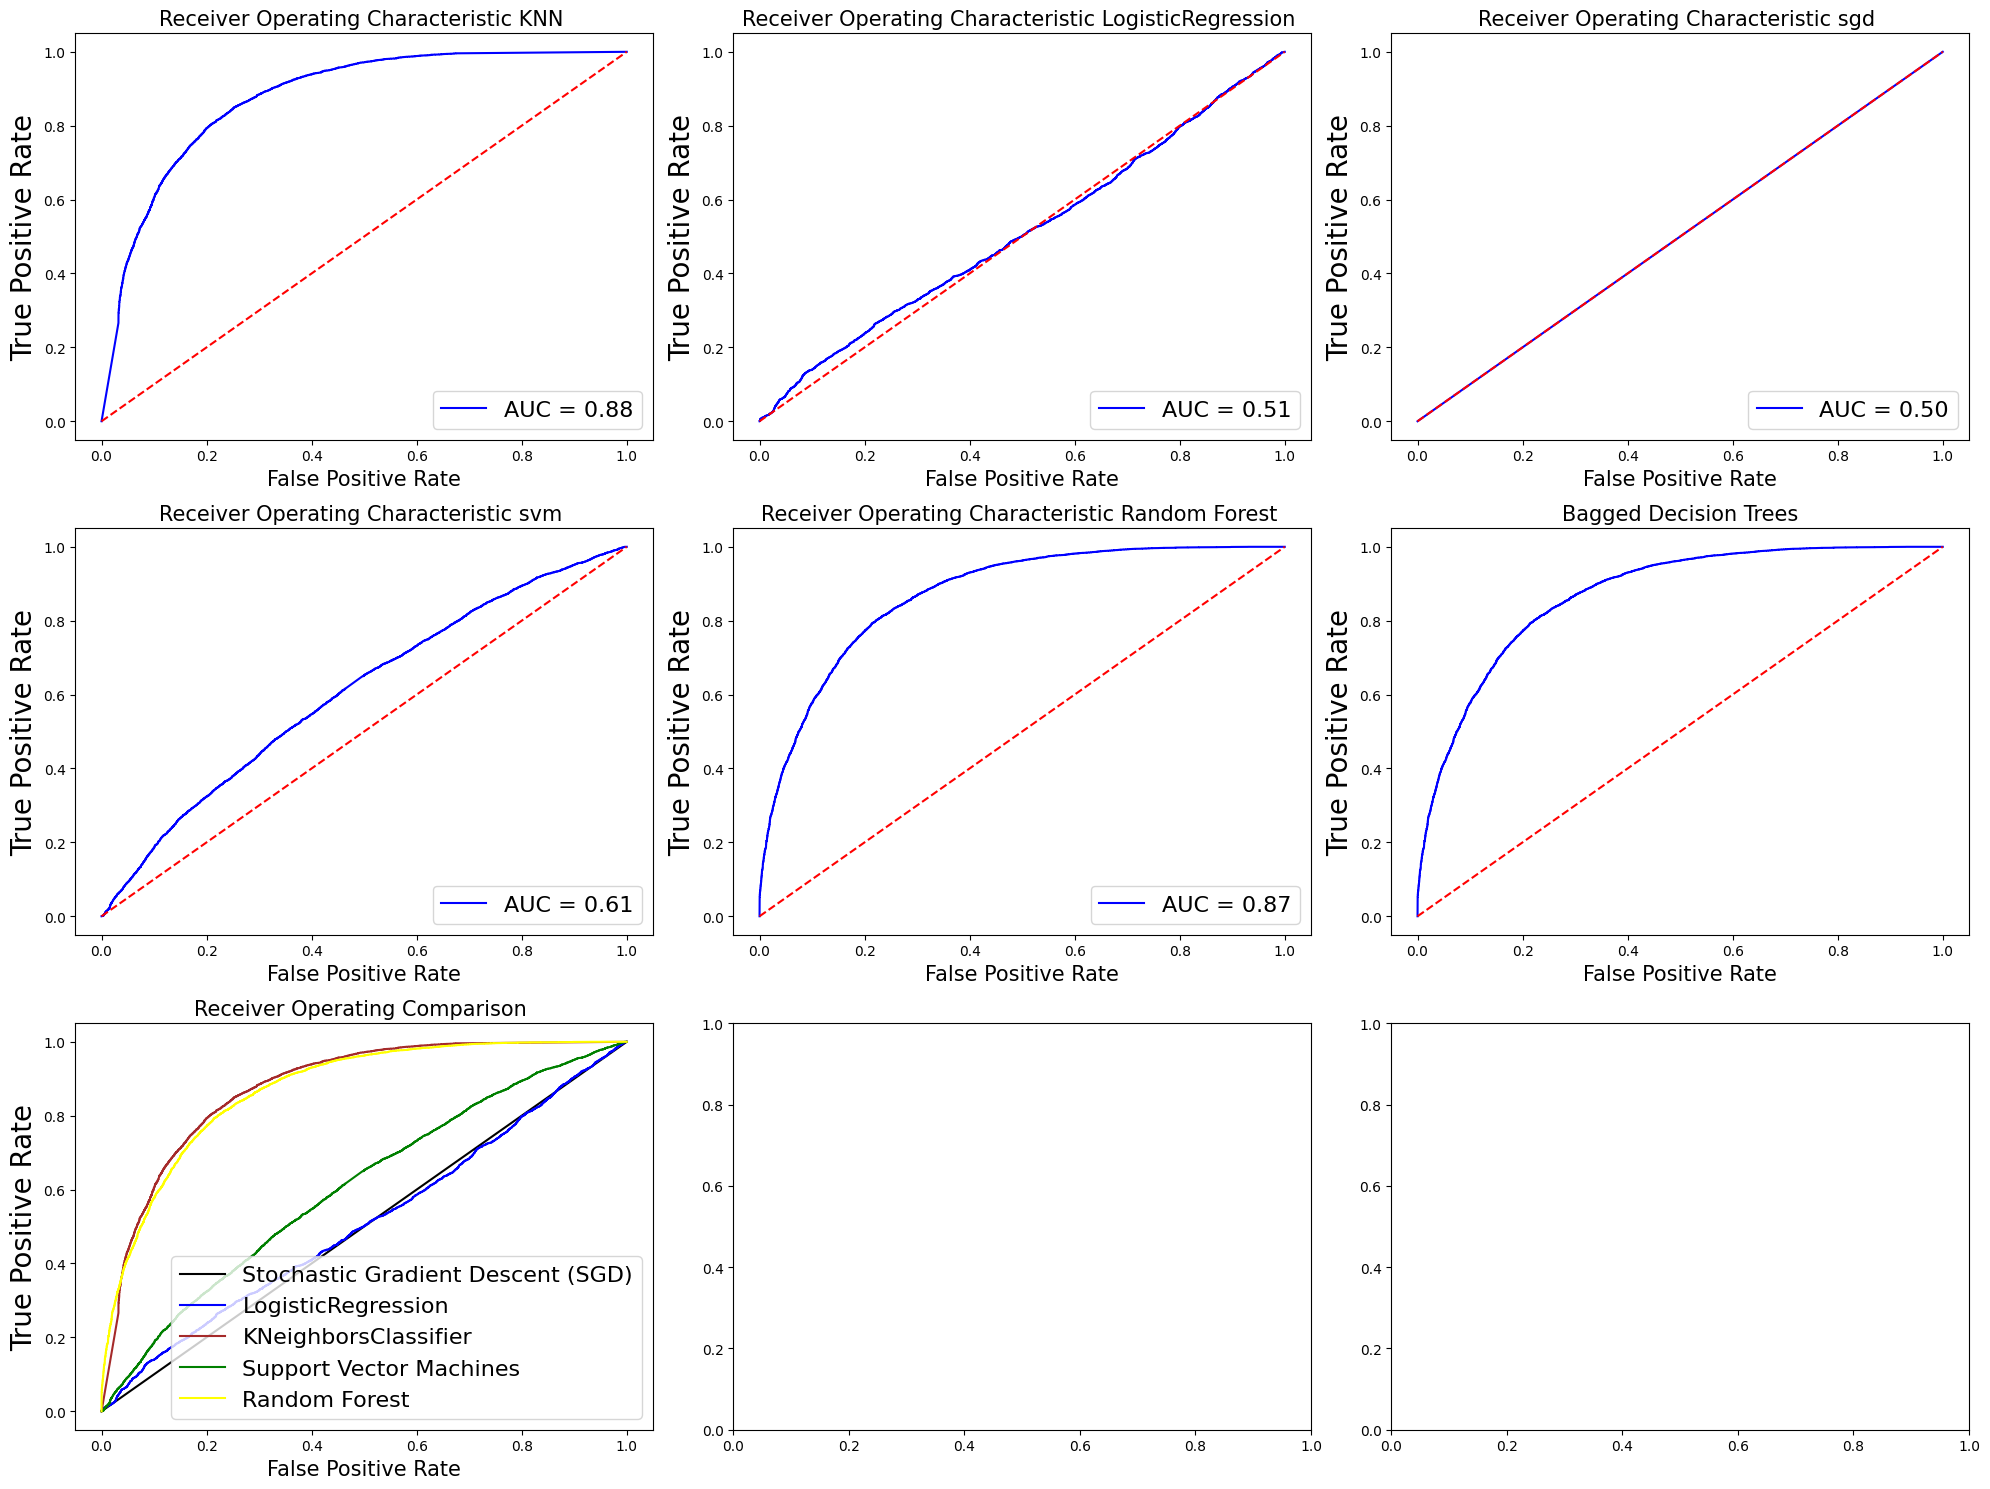

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt


fig, ax_arr = plt.subplots(nrows = 3, ncols = 3, figsize = (20,15))

#KNN----------------------
knn = KNeighborsClassifier(algorithm='auto',n_neighbors=8,weights='distance')
knn.fit(x_train, y_train)
probs = knn.predict_proba(x_test)
preds = probs[:,1]
fpr_knn, tpr_knn, threshold_knn = metrics.roc_curve(y_test, preds)
roc_auc_knn = metrics.auc(fpr_knn, tpr_knn)

ax_arr[0,0].plot(fpr_knn, tpr_knn, 'b', label = 'AUC = %0.2f' % roc_auc_knn)
ax_arr[0,0].plot([0, 1], [0, 1],'r--')
ax_arr[0,0].set_title('Receiver Operating Characteristic KNN ',fontsize=15)
ax_arr[0,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,0].legend(loc = 'lower right', prop={'size': 16})

#LogisticRegression ---------------------
log = LogisticRegression(C=0.1,class_weight='balanced',multi_class='auto',penalty='l1',solver='liblinear')
log.fit(x_train, y_train)
probs = log.predict_proba(x_test)
preds = probs[:,1]
fpr_log, tpr_log, threshold_log = metrics.roc_curve(y_test, preds)
roc_auc_dtree = metrics.auc(fpr_log, tpr_log)

ax_arr[0,1].plot(fpr_log, tpr_log, 'b', label = 'AUC = %0.2f' % roc_auc_dtree)
ax_arr[0,1].plot([0, 1], [0, 1],'r--')
ax_arr[0,1].set_title('Receiver Operating Characteristic LogisticRegression ',fontsize=15)
ax_arr[0,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,1].legend(loc = 'lower right', prop={'size': 16})

#sgd ---------------------
sgd = SGDClassifier(alpha=0.1,epsilon=0.1,l1_ratio=0.9,penalty='elasticnet')
sgd.fit(x_train, y_train)
calibrator = CalibratedClassifierCV(sgd, cv='prefit')
model=calibrator.fit(x_train, y_train)
probs = model.predict_proba(x_test)
preds = probs[:,1]
fpr_sgd, tpr_sgd, threshold_sgd = metrics.roc_curve(y_test, preds)
roc_auc_gau = metrics.auc(fpr_sgd, tpr_sgd)

ax_arr[0,2].plot(fpr_sgd, tpr_sgd, 'b', label = 'AUC = %0.2f' % roc_auc_gau)
ax_arr[0,2].plot([0, 1], [0, 1],'r--')
ax_arr[0,2].set_title('Receiver Operating Characteristic sgd ',fontsize=15)
ax_arr[0,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,2].legend(loc = 'lower right', prop={'size': 16})

#svm ---------------------
svm = SVC(C=100,gamma=1,kernel='rbf',probability=True)
svm.fit(x_train, y_train)
probs = svm.predict_proba(x_test)
preds = probs[:,1]
fpr_svm, tpr_svm, threshold_svm = metrics.roc_curve(y_test, preds)
roc_auc_gau = metrics.auc(fpr_svm, tpr_svm)

ax_arr[1,0].plot(fpr_svm, tpr_svm, 'b', label = 'AUC = %0.2f' % roc_auc_gau)
ax_arr[1,0].plot([0, 1], [0, 1],'r--')
ax_arr[1,0].set_title('Receiver Operating Characteristic svm ',fontsize=15)
ax_arr[1,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,0].legend(loc = 'lower right', prop={'size': 16})


#rfc ---------------------
rfc = RandomForestClassifier(bootstrap=True,max_depth=90,max_features=2,min_samples_leaf=3,min_samples_split=8,n_estimators=300)
rfc.fit(x_train, y_train)
probs = rfc.predict_proba(x_test)
preds = probs[:,1]
fpr_rfc, tpr_rfc, threshold_rfc = metrics.roc_curve(y_test, preds)
roc_auc_gau = metrics.auc(fpr_rfc, tpr_rfc)

ax_arr[1,1].plot(fpr_rfc, tpr_rfc, 'b', label = 'AUC = %0.2f' % roc_auc_gau)
ax_arr[1,1].plot([0, 1], [0, 1],'r--')
ax_arr[1,1].set_title('Receiver Operating Characteristic Random Forest ',fontsize=15)
ax_arr[1,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,1].legend(loc = 'lower right', prop={'size': 16})


#Bagged Decision Trees ----------------------------------
tree = DecisionTreeClassifier()
bagging_clf = BaggingClassifier(estimator=tree, n_estimators=1500, random_state=42)
bagging_clf.fit(x_train, y_train)
probs = bagging_clf.predict_proba(x_test)
preds = probs[:,1]
fpr_bdt, tpr_bdt, threshold_bdt = metrics.roc_curve(y_test, preds)
roc_auc_gau = metrics.auc(fpr_bdt, tpr_bdt)

ax_arr[1,2].plot(fpr_rfc, tpr_rfc, 'b', label = 'AUC = %0.2f' % roc_auc_gau)
ax_arr[1,2].plot([0, 1], [0, 1],'r--')
ax_arr[1,2].set_title('Bagged Decision Trees',fontsize=15)
ax_arr[1,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[1,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[1,1].legend(loc = 'lower right', prop={'size': 16})

#ALL PLOTS ----------------------------------
ax_arr[2,0].plot(fpr_sgd, tpr_sgd, 'b', label = 'Stochastic Gradient Descent (SGD)', color='black')
ax_arr[2,0].plot(fpr_log, tpr_log, 'b', label = 'LogisticRegression', color='blue')
ax_arr[2,0].plot(fpr_knn, tpr_knn, 'b', label = 'KNeighborsClassifier', color='brown')
ax_arr[2,0].plot(fpr_svm, tpr_svm, 'b', label = 'Support Vector Machines', color='green')
ax_arr[2,0].plot(fpr_rfc, tpr_rfc, 'b', label = 'Random Forest', color='yellow')
ax_arr[2,0].set_title('Receiver Operating Comparison ',fontsize=15)
ax_arr[2,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[2,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[2,0].legend(loc = 'lower right', prop={'size': 16})

plt.subplots_adjust(wspace=0.2)
plt.tight_layout() 

## Bonus - Analisis de sentimientos  

In [28]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\migue\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [29]:

from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

res = {}
for i, row in training_data.iterrows():
    text = row['tweet']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

In [33]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(training_data, how='left')

vaders.head()

id    neg    neu    pos  compound  label  \
0   1  0.655  0.345  0.000   -0.7650      0   
1   2  0.000  0.667  0.333    0.6705      0   
2   3  0.000  1.000  0.000    0.0000      0   
3   4  0.000  0.488  0.512    0.6369      0   
4   5  0.000  0.455  0.545    0.3400      0   

                                               tweet  
0  father dysfunctional selfish drags kids dysfun...  
1  thanks lyft credit cant use cause dont offer w...  
2                                     bihday majesty  
3                        model love u take u time ur  
4                      factsguide society motivation

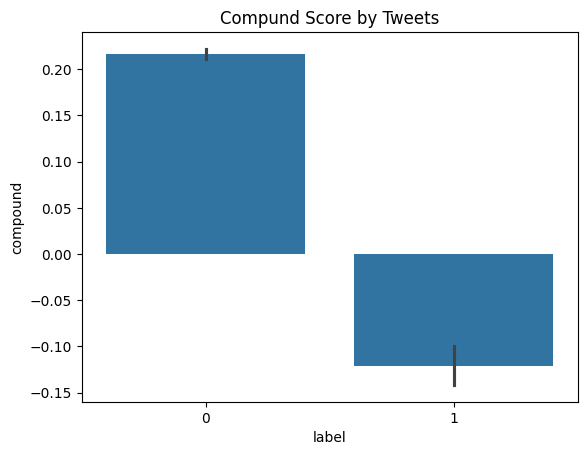

In [37]:
ax = sns.barplot(data=vaders, x='label', y='compound')
ax.set_title('Compund Score by Tweets')
plt.show()

Compounf hace refererncia a la suma de la nota positiva, neutra y negativa. el resultado se normaliza y dará algo entre -1 y +1. Como se observa en el caso de los tweets etiquetados como con hate speech son mayormente negativos.

# Comparación de algoritmos de regresión linear

## LinearRegression , Ridge , DecisionTreeRegressor , KNeighborsRegressor

Aquí vamos a comparar varios algoritmos de regresión linear, para ello vamos almacenando los resultados obtenidos en un map. Para cada algoritmo aplicamos el método que practicamos anteriormente y así encontramos sus valores óptimos.

In [13]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

l_regression = linear_model.LinearRegression() # metodo de regresion
kf = KFold(n_splits=10)
scores = cross_val_score(l_regression, X, y, cv=kf, scoring='neg_mean_squared_error')#metemos dataset entero y el lo rompe en trozos
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

#guarda los resultados en un array
scores_map = {}
scores_map['LinearRegression'] = scores


l_ridge = linear_model.Ridge()# otro metodo de regresion
scores = cross_val_score(l_ridge, X, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['Ridge'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))




desc_tr = DecisionTreeRegressor(max_depth=5)
grid_sv = GridSearchCV(desc_tr, cv=kf, param_grid={"max_depth" : [1, 2, 3, 4, 5, 6, 7],
                                                  "max_features":['auto', 'sqrt', 'log2']}, scoring='neg_mean_squared_error')
grid_sv.fit(X, y)
print("Best classifier :", grid_sv.best_estimator_)

scores = cross_val_score(desc_tr, X, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['DecisionTreeRegressor'] = scores
print("MSE: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))



knn = KNeighborsRegressor(n_neighbors=7)
scores = cross_val_score(knn, X, y, cv=kf, scoring='neg_mean_squared_error')
scores_map['KNeighborsRegressor'] = scores
grid_sv = GridSearchCV(knn, cv=kf, param_grid={"n_neighbors" : [2, 3, 4, 5, 6, 7]}, scoring='neg_mean_squared_error')
grid_sv.fit(X, y)

print("Best classifier :", grid_sv.best_estimator_)
print("KNN Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

MSE: -0.33 (+/- 0.05)
MSE: -0.33 (+/- 0.05)
Best classifier : DecisionTreeRegressor(max_depth=1, max_features='sqrt')
MSE: -0.63 (+/- 0.31)
Best classifier : KNeighborsRegressor(n_neighbors=7)
KNN Accuracy: -0.52 (+/- 0.36)


<Axes: >

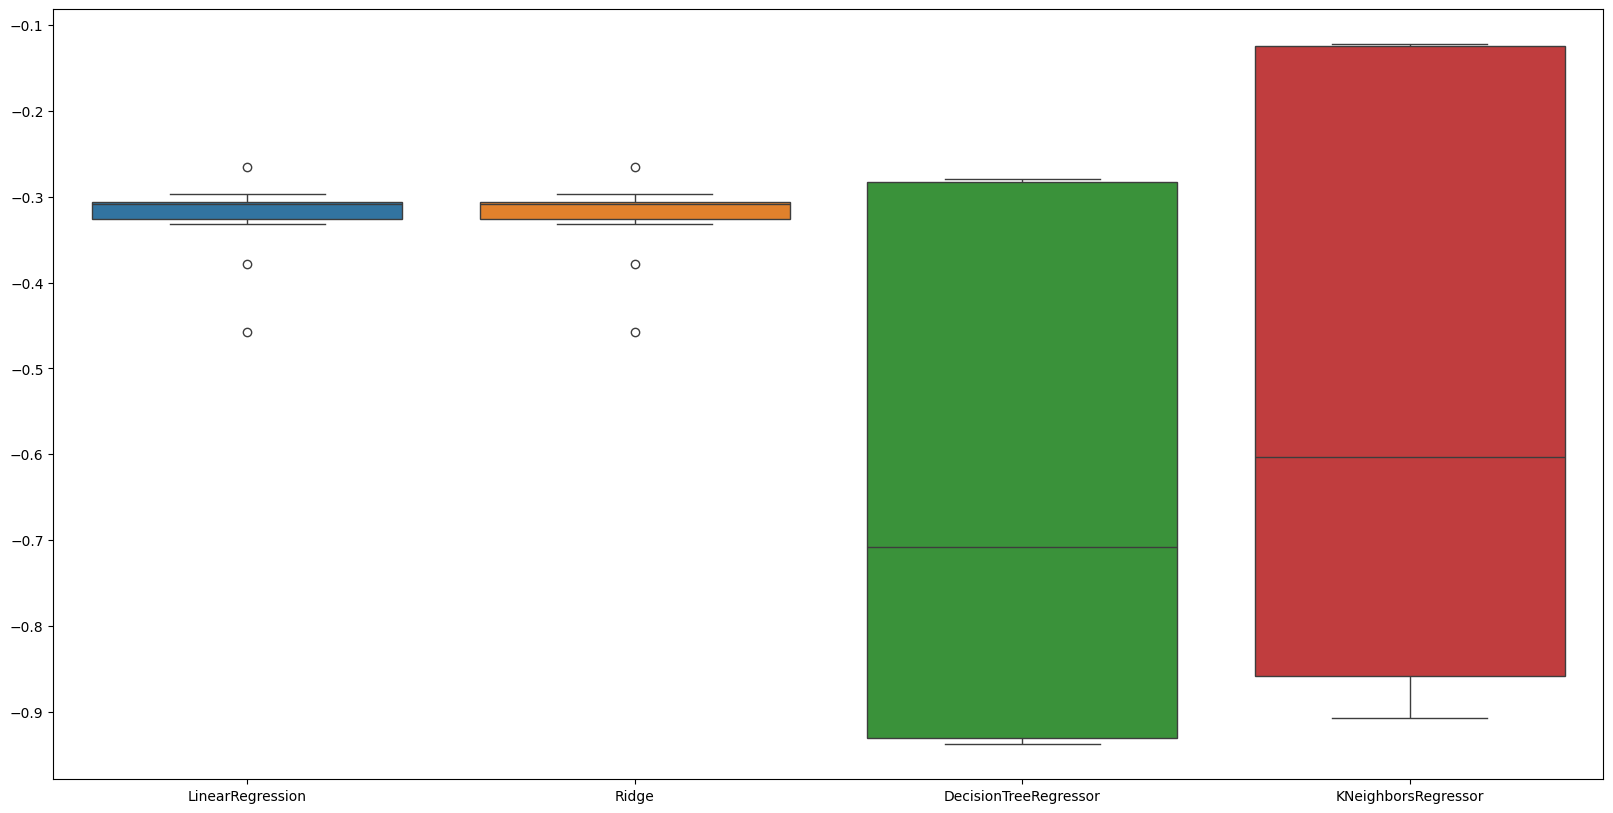

In [14]:
plt.figure(figsize=(20, 10))
scores_map = pd.DataFrame(scores_map)
sns.boxplot(data=scores_map)

## Aplicación a Steam

In [38]:
steam_reviews.head()

review_text
0                                    Ruined my life.
1  This will be more of a ''my experience with th...
2                      This game saved my virginity.
3  • Do you like original games? • Do you like ga...
4           Easy to learn, hard to master.

In [43]:
stop_words = set(stopwords.words('english'))
def limpiado_steam (review):
    if(isinstance(review, float)):
        print(review)
    
    review = re.sub(r"https\S+|www\S+http\S+", '', review, flags = re.MULTILINE)
    review = re.sub(r'\@w+|\#','', review)
    review = re.sub(r'[^\w\s]','',review)
    review = re.sub(r'ð','',review)
    review = re.sub(r'____________________________________','',review)
    review = re.sub(r'user','', review)
    review = re.sub(r'\d+', '', review)
    review = review.lower()
    review_tokens = word_tokenize(review)
    filtered_reviews = [w for w in review_tokens if not w in stop_words]
    return " ".join(filtered_reviews)


#steam_reviews = steam_reviews.dropna()
#steam_reviews.review_text = steam_reviews['review_text'].apply(limpiado_steam)
#steam_reviews = steam_reviews.drop_duplicates('review_text')

id  label                                              tweet
0   1      0  father dysfunctional selfish drags kids dysfun...
1   2      0  thanks lyft credit cant use cause dont offer w...
2   3      0                                     bihday majesty
3   4      0                        model love u take u time ur
4   5      0                      factsguide society motivation

In [45]:
#steam_reviews.to_csv('steam_reviews_tratadas.csv')

In [2]:
steam_reviews_tratado = pd.read_csv("./data/steam_reviews_tratadas.csv")

In [16]:
steam_reviews_tratado.head()

id                                        review_text
0   0                                        ruined life
1   1  experience game type review saying things like...
2   2                               game saved virginity
3   3  like original games like games dont lag like g...
4   4                             easy learn hard master

In [15]:
Label_y=LabelEncoder()
y = training_data['id'] 
X = X.apply(LabelEncoder().fit_transform)
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)

In [16]:
knn = KNeighborsClassifier(algorithm='auto',n_neighbors=8,weights='distance')
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=8, weights='distance')

[0 0 0 ... 1 1 1]
       labels
0           0
1           0
2           0
3           1
4           0
...       ...
53023       1
53024       1
53025       1
53026       1
53027       1

[53028 rows x 1 columns]


<Axes: xlabel='labels', ylabel='count'>

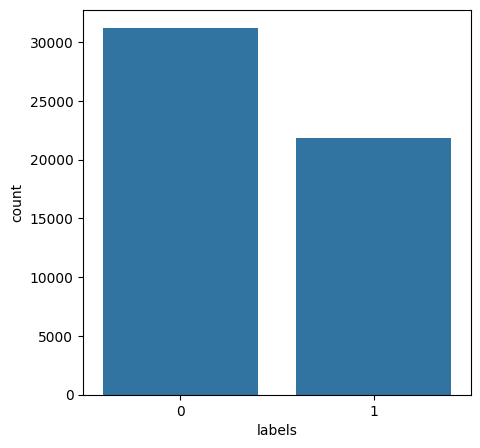

In [17]:
import numpy as np
resultado = knn.predict(X)

#fig = plt.figure(figsize=(5,5))
#sns.countplot(x='label', data = resultado)

print(resultado)
df = pd.DataFrame(resultado, columns=['labels'])

print(df)

fig = plt.figure(figsize=(5,5))
sns.countplot(x='labels', data = df)

In [37]:

tree = DecisionTreeClassifier()

bg = BaggingClassifier(estimator=tree, n_estimators=400,
                  random_state=42 )
bg.fit(x_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=400,
                  random_state=42)

       labels
0           0
1           0
2           1
3           0
4           0
...       ...
53023       0
53024       0
53025       0
53026       1
53027       1

[53028 rows x 1 columns]


<Axes: xlabel='labels', ylabel='count'>

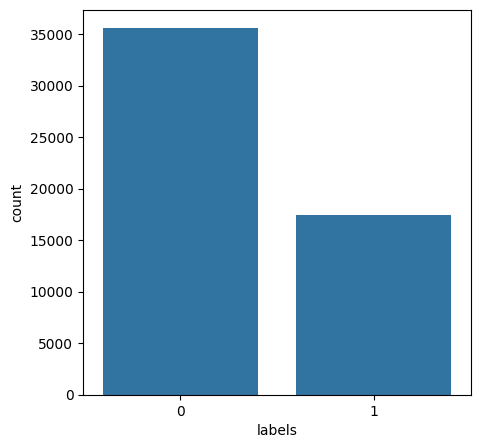

In [38]:
resultado = bg.predict(X)
df = pd.DataFrame(resultado, columns=['labels'])

print(df)

fig = plt.figure(figsize=(5,5))
sns.countplot(x='labels', data = df)

In [16]:

dtt = RandomForestClassifier(bootstrap=True,max_depth=80,max_features=3,min_samples_leaf=3,min_samples_split=8,n_estimators=300)
dtt.fit(x_train, y_train)

RandomForestClassifier(max_depth=80, max_features=3, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=300)

[0 0 0 ... 1 1 1]
       labels
0           0
1           0
2           0
3           0
4           0
...       ...
53023       1
53024       1
53025       1
53026       1
53027       1

[53028 rows x 1 columns]


<Axes: xlabel='labels', ylabel='count'>

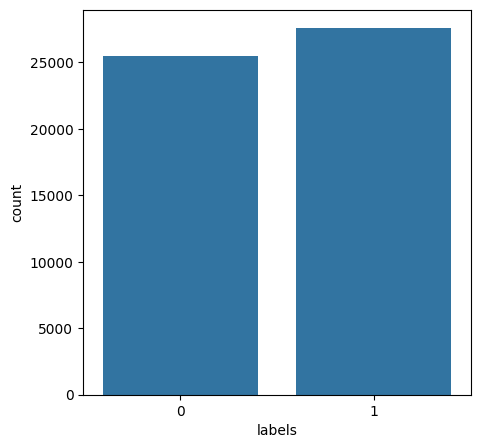

In [17]:
import numpy as np
resultado = dtt.predict(X)

print(resultado)
df = pd.DataFrame(resultado, columns=['labels'])

print(df)

fig = plt.figure(figsize=(5,5))
sns.countplot(x='labels', data = df)

In [5]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

res = {}
for i, row in steam_reviews_tratado.iterrows():
    text = row['review_text']
    myid = row['id']
    res[myid] = sia.polarity_scores(str(text))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\migue\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(training_data, how='left')

vaders.head()

id    neg    neu    pos  compound  label  \
0   0  0.756  0.244  0.000   -0.4767    NaN   
1   1  0.078  0.613  0.310    0.9952    0.0   
2   2  0.000  0.417  0.583    0.4215    0.0   
3   3  0.071  0.442  0.487    0.8817    0.0   
4   4  0.222  0.317  0.460    0.3612    0.0   

                                               tweet  
0                                                NaN  
1   @user when a father is dysfunctional and is s...  
2  @user @user thanks for #lyft credit i can't us...  
3                                bihday your majesty  
4  #model   i love u take with u all the time in ...

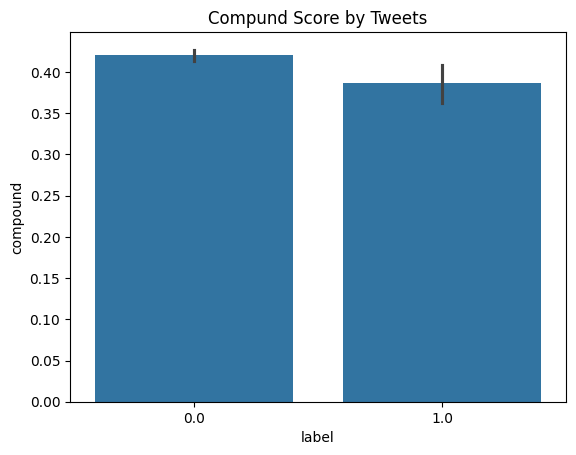

In [8]:
ax = sns.barplot(data=vaders, x='label', y='compound')
ax.set_title('Compund Score by Tweets')
plt.show()

In [26]:
from sklearn.neighbors import KNeighborsRegressor

knnReg = KNeighborsRegressor(algorithm='auto',n_neighbors=8,weights='distance')
knnReg.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=8, weights='distance')

[0 0 0 ... 1 1 1]
       labels
0           0
1           0
2           0
3           1
4           0
...       ...
53023       1
53024       1
53025       1
53026       1
53027       1

[53028 rows x 1 columns]


<Axes: xlabel='labels', ylabel='count'>

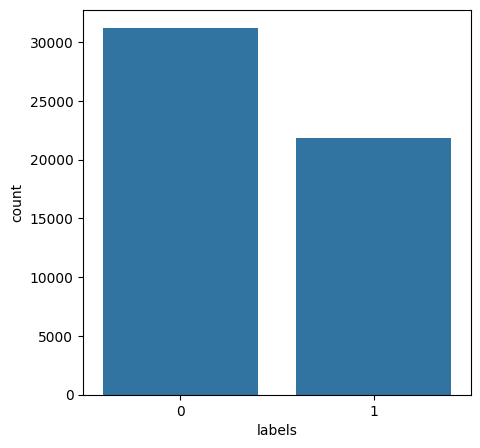

In [27]:
import numpy as np
resultado = knn.predict(X)

#fig = plt.figure(figsize=(5,5))
#sns.countplot(x='label', data = resultado)

print(resultado)
df = pd.DataFrame(resultado, columns=['labels'])

print(df)

fig = plt.figure(figsize=(5,5))
sns.countplot(x='labels', data = df)